Импортируем библиотеки:

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import nn
from sklearn.feature_selection import SelectKBest

%matplotlib inline

Загружаем данные из CSV. Данные преобразовываются в CSV с помощью утилиты `make_dataset`, которая собирается вместе с `SoFCheck`'ом

In [2]:
data = pd.read_csv('dataset.csv')

In [3]:
data

,winner,game_id,board_total,board_left,psq.cost.0,psq.cost.1,psq.cost.2,psq.cost.3,psq.cost.4,psq.cost.5,...,psq.king_end.59,psq.king_end.60,psq.king_end.61,psq.king_end.62,psq.king_end.63,queen_near_to_king,two_bishops,pawn_isolated,pawn_double,pawn_protected
0,0.5,1818,125,111,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,44977,223,70,-256,0,-256,256,0,0,...,0,0,0,0,0,0,0,256,0,-256
2,0.5,18156,90,48,0,0,0,0,0,0,...,0,43,0,-43,0,0,0,-256,-256,256
3,0.5,46647,79,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,768,0,-256
4,1.0,97582,138,106,0,0,-256,256,0,0,...,0,0,0,0,0,0,0,0,256,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,0.5,88039,138,128,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-512
2999996,1.0,68933,168,47,256,0,0,0,0,0,...,0,0,0,0,0,0,0,256,0,0
2999997,0.5,32197,143,42,256,0,0,0,0,0,...,0,0,0,0,0,0,0,256,0,0
2999998,0.5,50825,150,138,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,256


In [4]:
dv = data.values

Делим выборку на обучающую и тестовую. Деление осуществляем по `game_id`, чтобы позиции из одной игры не оказались в разных выборках.

In [5]:
games = np.array([i+1 for i in range(data['game_id'].max())])

games_train, games_test = train_test_split(games, test_size=0.1, shuffle=True)

In [6]:
train_set = set(games_train)
test_set = set(games_test)

is_train = np.vectorize(lambda x: x in train_set)
is_test = np.vectorize(lambda x: x in test_set)

dv_train = dv[is_train(dv[:,1])]
dv_test = dv[is_test(dv[:,1])]

In [7]:
del data
del dv

In [8]:
X = dv_train[:,4:]
y = dv_train[:,0]
w = dv_train[:,3]

X_test = dv_test[:,4:]
y_test = dv_test[:,0]
w_test = dv_test[:,3]

del dv_train
del dv_test

Создаем нашу модель. Здесь используется модель, описанная [на Хабре](https://habr.com/ru/post/305604/), только мы не пишем градиентный спуск руками, а используем силу PyTorch

In [31]:
model = nn.Sequential()
model.add_module('linear', nn.Linear(X.shape[1], 1, bias=False))
model.add_module('sigmoid', nn.Sigmoid())

In [32]:
opt = torch.optim.Adam(model.parameters(), lr=5e-5)

Определяем функцию потерь:

In [33]:
def get_loss(model, X, y, w, C=0.0):
    w = np.exp(-w / 32.)
    y_pred = model(X)[:, 0]
    assert y_pred.dim() == 1
    loss = torch.sum(w * ((y - y_pred) ** 2)) / torch.sum(w)
    loss += C * torch.norm(model.linear.weight, 1)
    return loss

Обучаем, пока не сойдется функция потерь. Для этого может быть полезно запустить ячейку несколько раз. А может быть, ее стоит остановить раньше.

In [34]:
C = 0.004

history = []

for i in range(6000):
    # собираем батч
    indices = np.random.randint(0, X.shape[0], 8000)
    X_batch = torch.tensor(X[indices], dtype=torch.float32)
    y_batch = torch.tensor(y[indices], dtype=torch.float32)
    w_batch = torch.tensor(w[indices], dtype=torch.float32)
    
    # считаем функцию потерь
    loss = get_loss(model, X_batch, y_batch, w_batch, C=C)

    loss.backward()
    
    # надо раскомментить, если хочется менять только короля
    # model.linear.weight.grad[0, 0:6+64] = 0
    # model.linear.weight.grad[0, 6+64:6+384] = 0
    # model.linear.weight.grad[0, 6+448:] = 0
    
    # оптимизируем
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())

    # выводим результаты
    if i % 100 == 0:
        test_loss = get_loss(model,
            torch.tensor(X_test, dtype=torch.float32),
            torch.tensor(y_test, dtype=torch.float32),
            torch.tensor(w_test, dtype=torch.float32),
            C=0.0).detach().numpy().sum()
        train_loss = np.mean(history[-40:])
        print(f"step #{i}, train_loss = {train_loss:.4f}, test_loss = {test_loss:.4f}")

step #0, train_loss = 0.5440, test_loss = 0.5184
step #100, train_loss = 0.5297, test_loss = 0.4741
step #200, train_loss = 0.4754, test_loss = 0.4214
step #300, train_loss = 0.4191, test_loss = 0.3664
step #400, train_loss = 0.3662, test_loss = 0.3199
step #500, train_loss = 0.3274, test_loss = 0.2832
step #600, train_loss = 0.2962, test_loss = 0.2557
step #700, train_loss = 0.2720, test_loss = 0.2343
step #800, train_loss = 0.2516, test_loss = 0.2171
step #900, train_loss = 0.2338, test_loss = 0.2028
step #1000, train_loss = 0.2182, test_loss = 0.1906
step #1100, train_loss = 0.2060, test_loss = 0.1800
step #1200, train_loss = 0.1945, test_loss = 0.1707
step #1300, train_loss = 0.1840, test_loss = 0.1620
step #1400, train_loss = 0.1727, test_loss = 0.1531
step #1500, train_loss = 0.1617, test_loss = 0.1437
step #1600, train_loss = 0.1499, test_loss = 0.1328
step #1700, train_loss = 0.1336, test_loss = 0.1166
step #1800, train_loss = 0.1118, test_loss = 0.0964
step #1900, train_loss =

KeyboardInterrupt: 

Смотрим на итоговое значение функции потерь на тестовом датасете:

In [35]:
test_loss = get_loss(model,
                     torch.tensor(X_test, dtype=torch.float32),
                     torch.tensor(y_test, dtype=torch.float32),
                     torch.tensor(w_test, dtype=torch.float32)).detach().numpy().sum()
test_loss

0.056135513

Ради интереса посмотрим на вероятности, которые предсказывает модель для каких-то $20$ соседних примеров тестовой выборки:

In [36]:
res = model(torch.tensor(X_test, dtype=torch.float32))[:, 0]

print(res[450:470], y_test[450:470])

tensor([0.6759, 0.9633, 0.5354, 0.5364, 0.5798, 0.4820, 0.9982, 0.5289, 0.2316,
        0.5607, 0.2306, 0.4833, 0.4168, 0.5666, 0.1450, 0.5402, 0.9990, 0.2048,
        0.9753, 0.6415], grad_fn=<SliceBackward>) [0.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.5 0.5 1.  0.  0.  1.  0.
 1.  1. ]


Теперь было бы неплохо преобразовать веса модели в коэффициенты, которые мы будем использовать в шахматной программе. Для этого нормируем таблицы фигура-поле так, чтобы медианное значение занулилось. Затем умножим все веса на одно и то же число так, чтобы стоимость пешки была равна `100` (т. е. одной пешке)

In [39]:
ws = (model.linear.weight[0]).detach().numpy()
for p in [0, 2, 3, 4, 5]:
    left = 6 + 64 * p
    right = 6 + 64 * (p + 1)
    if p == 0:
        # верхний и нижний ряд у пешки не используется, не обращаем на него внимание
        left += 8
        right -= 8
    m = np.median(ws[left:right])
    ws[left:right] -= m
    ws[p] += m

ww = (ws / ws[0] * 100).astype(np.int32)
print(ww)

[100   0 275 296 478 873   0   0   0   0   0   0   0   0 139 153 158 116
 140 132 152 104  72  76  62  58  46  56  79  61  18  14   0  -2  14  -6
   5   7  -6   0  -8 -12 -16  -9  -8 -13 -11 -12 -19 -20 -12 -13   0 -11
 -17  -2 -11 -44 -12   0  11 -17   0   0   0   0   0   0   0   0   0   0
   0   0  -1   0   0   0   1   1   0   0  -1   1   0   0   0   3  -1   0
   0   1   0  -1   0   1  -2  -2   0   1   0   1   1   1   0  -2   0   2
   3  -1   2   0   0  -1   1  11 -17  -6  -1 -10  -1   2  -3   2   8  43
 -31  25  -3 -32 -14 -64  46  29   1   0   5   0 -10   3   1   0  -7  -1
   6  -4  23   9  -2 -23  -9  -4  33  26  41  33  17   0  -8   1  21  48
  42  47  32  19 -22  -7  16  15  28  23  11  21 -43 -27   0   4  24  16
   6   0 -46  -9  -2   0 -11 -10  -6   0 -69 -63 -24 -18  -9 -11   0 -49
   0   2  -6   0  -8   2  -2   1 -32  -1   3   2  -7   3   1  -7 -17  -8
   0   9  13  23   0  31   1  -3  23  11   7  10  10   1  -1  -3   3  18
  12  -1   2  12  -9  11   6  14  -2   9   0  -6  -

Эти веса уже можно скопировать, вставить в утилиту `apply_weigths` и использовать в `SoFCheck`'е.

Далее визуализируем полученные веса:

In [40]:
def display_mat(mat):
    plt.matshow(mat)
    for (x, y), value in np.ndenumerate(mat):
        plt.text(y, x, f"{value}", va="center", ha="center")

Стоимости фигур:

In [41]:
ww[:6]

array([100,   0, 275, 296, 478, 873], dtype=int32)

Таблицы фигура-поле для пешки:

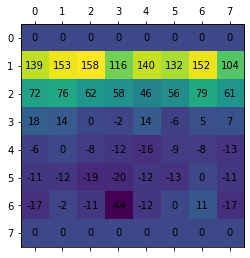

In [42]:
display_mat(ww[6:6+64].reshape(8, 8))

Таблицы фигура-поле для короля в миттельшпиле:

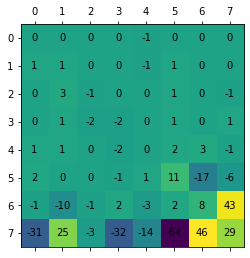

In [43]:
display_mat(ww[6+64:6+128].reshape(8, 8))

Таблицы фигура-поле для коня:

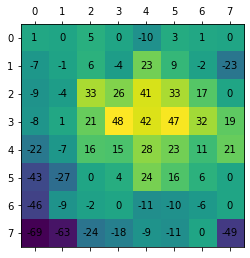

In [44]:
display_mat(ww[6+128:6+192].reshape(8, 8))

Таблицы фигура-поле для слона:

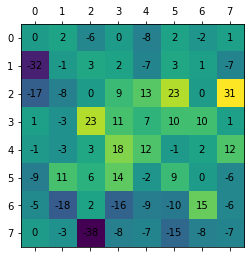

In [45]:
display_mat(ww[6+192:6+256].reshape(8, 8))

Таблицы фигура-поле для ладьи:

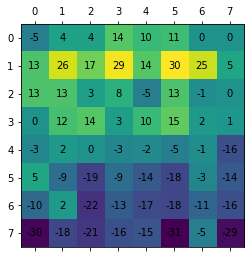

In [50]:
display_mat(ww[6+256:6+320].reshape(8, 8))

Таблицы фигура-поле для ферзя:

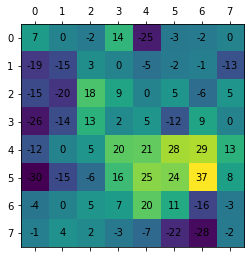

In [51]:
display_mat(ww[6+320:6+384].reshape(8, 8))

Таблицы фигура-поле для короля в эндшпиле:

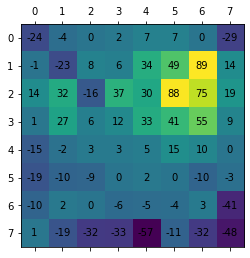

In [52]:
display_mat(ww[6+384:6+448].reshape(8, 8))

Стоимость ферзя, близкого к вражескому королю, и стоимость двух слонов:

In [53]:
ww[454], ww[455]

(40, 38)

Стоимость пешек: изолированная, двойная, защищенная:

In [54]:
ww[456], ww[457], ww[458]

(0, -24, 1)